# Next Purchase Prediction

What if you know if a customer is likely to make another purchase in 7 days?

You can build your strategy on top of that and come up with lots of tactical actions like:

- No promotional offer to this customer since s/he will make a purchase anyways
- Nudge the customer with inbound marketing if there is no purchase in the predicted time window (or fire the guy who did the prediction) 

**Outilne** 

- Feature Engineering
- Modeling
- Drowing a conclusion

Data for the analysis was taken from [kaggle](https://www.kaggle.com/mkechinov/ecommerce-purchase-history-from-jewelry-store).

### Data and Packages 

In [1]:
# Pachages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date
%matplotlib inline

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataset
data = pd.read_csv('jewelry.csv')
data.head()

,event_time,order_id,product_id,quantity,category_id,category_code,brand,price,user_id,gender,color,metal,gem
0,2018-11-29 16:30:45 UTC,1923415742179443254,1836250225916772582,1,1.806829e+18,jewelry.pendant,0.0,67.78,1.515916e+18,NaN,red,gold,diamond
1,2018-11-29 16:52:07 UTC,1923426489303302817,1836015460420681761,1,1.806829e+18,jewelry.pendant,0.0,32.63,1.515916e+18,NaN,red,gold,NaN
2,2018-11-29 17:58:37 UTC,1923459963229831173,1806829194936582544,1,1.806829e+18,jewelry.ring,1.0,75.21,1.515916e+18,NaN,red,gold,amethyst
3,2018-11-29 20:25:52 UTC,1923534078074684181,1835566854668550661,1,1.806829e+18,jewelry.earring,0.0,131.37,1.515916e+18,f,red,gold,NaN
4,2018-11-29 20:30:01 UTC,1923536169069445939,1836568752905257618,1,1.806829e+18,jewelry.bracelet,0.0,102.60,1.515916e+18,f,red,gold,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113302 entries, 0 to 113301
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     113302 non-null  object 
 1   order_id       113302 non-null  int64  
 2   product_id     113302 non-null  int64  
 3   quantity       113302 non-null  int64  
 4   category_id    112905 non-null  float64
 5   category_code  103674 non-null  object 
 6   brand          111936 non-null  float64
 7   price          112905 non-null  float64
 8   user_id        112905 non-null  float64
 9   gender         62223 non-null   object 
 10  color          110166 non-null  object 
 11  metal          112851 non-null  object 
 12  gem            77095 non-null   object 
dtypes: float64(4), int64(3), object(6)
memory usage: 11.2+ MB


In [4]:
cols = ['order_id', 'product_id', 'category_id', 'user_id']

for col in cols: 
    data[col] = data[col].astype('O')
    
data['event_time'] = pd.to_datetime(data['event_time'])

## EDA

As usual, we start with a quick exploratory data analysis. Describe the plots and draw conclusions.

In [5]:
def plot_continuous(dataset, var_name):
    sns.displot(dataset[var_name])
    plt.axvline(dataset[var_name].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(dataset[var_name].median(), color='r', linewidth=1)
    plt.title(f'Distribution of variable "{var_name}"')
    
def plot_objects(dataset, var_name):
    sns.countplot(dataset[var_name])
    plt.title(f'Distribution of variable "{var_name}"')

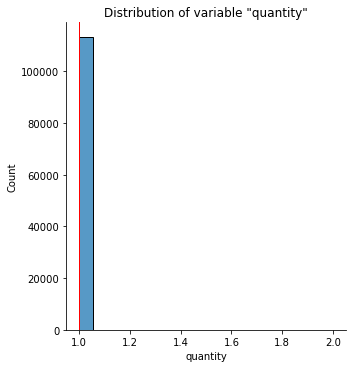

In [6]:
plot_continuous(data, 'quantity')

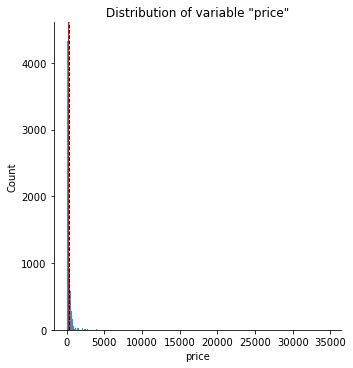

In [7]:
plot_continuous(data, 'price')

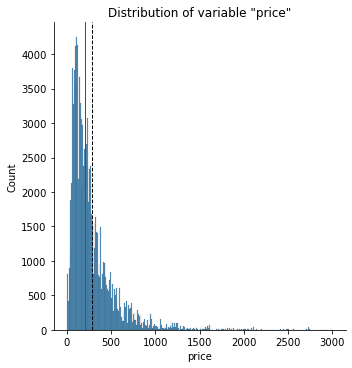

In [8]:
plot_continuous(data[data['price'] < 3000], 'price')

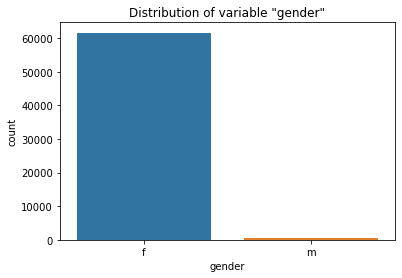

In [9]:
plot_objects(data, 'gender')

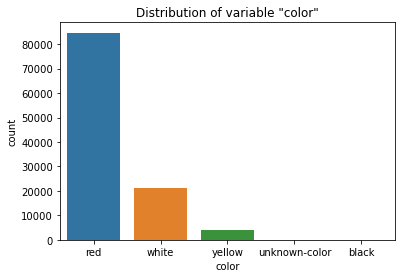

In [10]:
plot_objects(data, 'color')

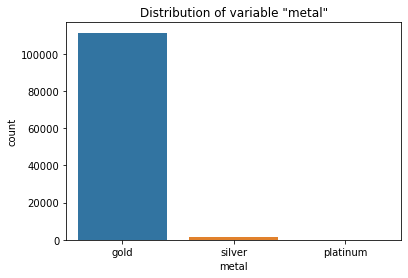

In [11]:
plot_objects(data, 'metal')

In [12]:
data.event_time.describe()

count                        113302
unique                        85458
top       2019-01-27 17:40:15+00:00
freq                             30
first     2018-11-29 16:30:45+00:00
last      2020-11-29 14:39:47+00:00
Name: event_time, dtype: object

We're going to use 6 months of data to make predictions.

In [13]:
purch_hist = data[(data.event_time < '2020-5-29')]
purch_next = data[(data.event_time >= '2020-5-29')].reset_index(drop=True)

In [14]:
customer  = pd.DataFrame(purch_hist['user_id'].unique())
customer.columns = ['user_id']

In [15]:
purch_hist.shape, purch_next.shape, customer.shape

((85323, 13), (27979, 13), (35047, 1))

### Labeling

In [16]:
next_ = purch_next.groupby('user_id').event_time.min().reset_index()
next_.columns = ['user_id','MinNextPurchase']
next_.head()

,user_id,MinNextPurchase
0,1.313554e+18,2020-06-27 17:17:01+00:00
1,1.313556e+18,2020-07-30 07:27:33+00:00
2,1.313591e+18,2020-09-21 03:23:39+00:00
3,1.313658e+18,2020-06-22 07:10:20+00:00
4,1.313673e+18,2020-07-05 15:52:35+00:00


In [17]:
last_ = purch_hist.groupby('user_id').event_time.max().reset_index()
last_.columns = ['user_id','MaxHistPurchase']
purchase = pd.merge(last_, next_,on='user_id',how='left')
purchase['NextPurchaseDay'] = (purchase['MinNextPurchase'] - purchase['MaxHistPurchase']).dt.days
purchase.head()

,user_id,MaxHistPurchase,MinNextPurchase,NextPurchaseDay
0,1.313556e+18,2019-08-02 10:00:19+00:00,2020-07-30 07:27:33+00:00,362.0
1,1.313556e+18,2019-09-18 10:06:37+00:00,NaT,NaN
2,1.313566e+18,2020-04-29 19:51:44+00:00,NaT,NaN
3,1.313568e+18,2019-10-29 08:54:50+00:00,NaT,NaN
4,1.313569e+18,2019-02-03 09:36:43+00:00,NaT,NaN


In [18]:
customer = pd.merge(customer, purchase[['user_id','NextPurchaseDay']],on='user_id',how='left')
print('Number of retained customers: ', customer.NextPurchaseDay.notna().sum())
customer = customer.fillna(-1)
customer.shape

Number of retained customers:  1538


(35047, 2)

###  New Features

In [19]:
day_order = purch_hist[['user_id','event_time']]
day_order = day_order.sort_values(['user_id','event_time'])
day_order = day_order.drop_duplicates(subset=['user_id','event_time'],keep='first')

# last 3 purchase dates
day_order['Previous'] = day_order.groupby('user_id')['event_time'].shift(1)
day_order['Previous2'] = day_order.groupby('user_id')['event_time'].shift(2)
day_order['Previous3'] = day_order.groupby('user_id')['event_time'].shift(3)


In [20]:
day_order.head(10)

,user_id,event_time,Previous,Previous2,Previous3
31657,1.31356e+18,2019-08-02 10:00:19+00:00,NaT,NaT,NaT
1026,1.31356e+18,2019-01-09 06:17:34+00:00,NaT,NaT,NaT
3473,1.31356e+18,2019-01-26 19:05:13+00:00,2019-01-09 06:17:34+00:00,NaT,NaT
38429,1.31356e+18,2019-09-18 10:06:37+00:00,2019-01-26 19:05:13+00:00,2019-01-09 06:17:34+00:00,NaT
20633,1.31357e+18,2019-05-21 09:33:00+00:00,NaT,NaT,NaT
82758,1.31357e+18,2020-04-29 19:50:22+00:00,2019-05-21 09:33:00+00:00,NaT,NaT
82759,1.31357e+18,2020-04-29 19:51:44+00:00,2020-04-29 19:50:22+00:00,2019-05-21 09:33:00+00:00,NaT
26916,1.31357e+18,2019-07-04 07:01:52+00:00,NaT,NaT,NaT
28043,1.31357e+18,2019-07-11 14:22:05+00:00,2019-07-04 07:01:52+00:00,NaT,NaT
44950,1.31357e+18,2019-10-29 08:54:50+00:00,2019-07-11 14:22:05+00:00,2019-07-04 07:01:52+00:00,NaT


In [21]:
data_nas = pd.DataFrame(day_order.isna().sum(), columns=['Number of NAs'])
data_nas['Percentage of NAs'] = round(data_nas['Number of NAs'] / day_order.shape[0] *100, 3)
data_nas

,Number of NAs,Percentage of NAs
user_id,243,0.378
event_time,0,0.000
Previous,35289,54.943
Previous2,43864,68.294
Previous3,47144,73.401


In [22]:
day_order['DayDiff'] = (day_order['event_time'] - day_order['Previous']).dt.days
day_order['DayDiff2'] = (day_order['event_time'] - day_order['Previous2']).dt.days
day_order['DayDiff3'] = (day_order['event_time'] - day_order['Previous3']).dt.days
day_order.head(10)

,user_id,event_time,Previous,Previous2,Previous3,DayDiff,DayDiff2,DayDiff3
31657,1.31356e+18,2019-08-02 10:00:19+00:00,NaT,NaT,NaT,NaN,NaN,NaN
1026,1.31356e+18,2019-01-09 06:17:34+00:00,NaT,NaT,NaT,NaN,NaN,NaN
3473,1.31356e+18,2019-01-26 19:05:13+00:00,2019-01-09 06:17:34+00:00,NaT,NaT,17.0,NaN,NaN
38429,1.31356e+18,2019-09-18 10:06:37+00:00,2019-01-26 19:05:13+00:00,2019-01-09 06:17:34+00:00,NaT,234.0,252.0,NaN
20633,1.31357e+18,2019-05-21 09:33:00+00:00,NaT,NaT,NaT,NaN,NaN,NaN
82758,1.31357e+18,2020-04-29 19:50:22+00:00,2019-05-21 09:33:00+00:00,NaT,NaT,344.0,NaN,NaN
82759,1.31357e+18,2020-04-29 19:51:44+00:00,2020-04-29 19:50:22+00:00,2019-05-21 09:33:00+00:00,NaT,0.0,344.0,NaN
26916,1.31357e+18,2019-07-04 07:01:52+00:00,NaT,NaT,NaT,NaN,NaN,NaN
28043,1.31357e+18,2019-07-11 14:22:05+00:00,2019-07-04 07:01:52+00:00,NaT,NaT,7.0,NaN,NaN
44950,1.31357e+18,2019-10-29 08:54:50+00:00,2019-07-11 14:22:05+00:00,2019-07-04 07:01:52+00:00,NaT,109.0,117.0,NaN


In [23]:
day_diff = day_order.groupby('user_id').agg({'DayDiff': ['mean','std']}).reset_index()
day_diff.columns = ['user_id', 'DayDiffMean','DayDiffStd']
day_diff.head()

,user_id,DayDiffMean,DayDiffStd
0,1.313556e+18,NaN,NaN
1,1.313556e+18,125.5,153.442172
2,1.313566e+18,172.0,243.244733
3,1.313568e+18,58.0,72.124892
4,1.313569e+18,2.0,1.414214


In [24]:
last_day = day_order.drop_duplicates(subset=['user_id'],keep='last')
last_day.head(5)

,user_id,event_time,Previous,Previous2,Previous3,DayDiff,DayDiff2,DayDiff3
31657,1.31356e+18,2019-08-02 10:00:19+00:00,NaT,NaT,NaT,NaN,NaN,NaN
38429,1.31356e+18,2019-09-18 10:06:37+00:00,2019-01-26 19:05:13+00:00,2019-01-09 06:17:34+00:00,NaT,234.0,252.0,NaN
82759,1.31357e+18,2020-04-29 19:51:44+00:00,2020-04-29 19:50:22+00:00,2019-05-21 09:33:00+00:00,NaT,0.0,344.0,NaN
44950,1.31357e+18,2019-10-29 08:54:50+00:00,2019-07-11 14:22:05+00:00,2019-07-04 07:01:52+00:00,NaT,109.0,117.0,NaN
5026,1.31357e+18,2019-02-03 09:36:43+00:00,2019-01-31 08:25:28+00:00,2019-01-29 08:29:27+00:00,NaT,3.0,5.0,NaN


In [25]:
last_day = pd.merge(last_day, day_diff, on='user_id')
customer = pd.merge(customer, last_day[['user_id','DayDiff', 'DayDiff2','DayDiffMean','DayDiffStd']], on='user_id')
customer = customer.fillna(-1)


len(customer)
# USE 'DayDiff3' in case you have more data

35046

In [26]:
customer.head()

,user_id,NextPurchaseDay,DayDiff,DayDiff2,DayDiffMean,DayDiffStd
0,1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0
2,1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0
3,1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0
4,1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0


In [27]:
customer.describe()

,user_id,NextPurchaseDay,DayDiff,DayDiff2,DayDiffMean,DayDiffStd
count,3.504600e+04,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000
mean,1.514161e+18,9.578554,8.132683,5.312618,8.060151,2.717304
std,1.692440e+16,58.183763,40.807500,35.368310,37.716419,20.148956
min,1.313556e+18,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.515916e+18,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,1.515916e+18,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,1.515916e+18,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,1.555252e+18,675.000000,528.000000,521.000000,528.000000,327.390440


In [28]:
other_features = data.groupby('user_id', as_index=False)['price'].mean()
#Add more if you have other handy features

In [29]:
final = pd.merge(customer, other_features, on= 'user_id', how = 'left')

final.set_index('user_id', inplace=True)
final.head()

,NextPurchaseDay,DayDiff,DayDiff2,DayDiffMean,DayDiffStd,price
user_id,,,,,,
1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0,67.78
1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0,32.63
1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0,75.21
1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0,131.37
1.515916e+18,-1.0,-1.0,-1.0,-1.0,-1.0,102.60


## Version 1: make a classification task

For the first model we are going to create labels for dataset. This may help to predict churn as well

In [30]:
final_v1 = final.copy()

In [31]:
final_v1.NextPurchaseDay.describe()

# Use final.NextPurchaseDay.describe(np.linspace(0,1,10)) to get percentiles of data

count    35046.000000
mean         9.578554
std         58.183763
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        675.000000
Name: NextPurchaseDay, dtype: float64

In [32]:
final_v1[final_v1['NextPurchaseDay'] > -1]['NextPurchaseDay'].describe() 

count    1538.000000
mean      240.050715
std       146.960690
min         0.000000
25%       128.250000
50%       214.000000
75%       327.750000
max       675.000000
Name: NextPurchaseDay, dtype: float64

In [33]:
final_v1['NextPurchase'] = 2 # returnd after 214 days
final_v1.loc[final_v1.NextPurchaseDay < 214,'NextPurchase'] = 1 #returned within 214 days
final_v1.loc[final_v1.NextPurchaseDay == -1,'NextPurchase'] = 0 #never retained

In [34]:
final_v1.NextPurchase.value_counts()/len(customer)*100 

0    95.611482
2     2.197112
1     2.191406
Name: NextPurchase, dtype: float64

In [35]:
final_v1 = final_v1.drop(columns='NextPurchaseDay')

In [36]:
final_v1.head()

,DayDiff,DayDiff2,DayDiffMean,DayDiffStd,price,NextPurchase
user_id,,,,,,
1.515916e+18,-1.0,-1.0,-1.0,-1.0,67.78,0
1.515916e+18,-1.0,-1.0,-1.0,-1.0,32.63,0
1.515916e+18,-1.0,-1.0,-1.0,-1.0,75.21,0
1.515916e+18,-1.0,-1.0,-1.0,-1.0,131.37,0
1.515916e+18,-1.0,-1.0,-1.0,-1.0,102.60,0


### Modeling

We have very imbalanced data. [Some of the techniques were covered in our last tutorial](https://github.com/LilitYolyan/customer_behavior_analysis/blob/master/Week_6_Churn_Analysis_Prediction.ipynb).

In [37]:
X, y = final_v1.drop('NextPurchase',axis=1), final_v1.NextPurchase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [38]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      6701
           1       0.14      0.13      0.14       161
           2       0.10      0.09      0.09       148

    accuracy                           0.93      7010
   macro avg       0.40      0.39      0.40      7010
weighted avg       0.93      0.93      0.93      7010

Accuracy: 0.9283880171184022


## Version 2: Classification only on retained customers

In the next step, we will only use those customers data who have not left. Thus, we can get a more accurate model and solve the problem of imbalanced data.

In [39]:
retained = final[final['NextPurchaseDay'] != -1]
retained.head()

,NextPurchaseDay,DayDiff,DayDiff2,DayDiffMean,DayDiffStd,price
user_id,,,,,,
1.515916e+18,437.0,0.0,53.0,27.500000,32.649655,181.250000
1.515916e+18,606.0,-1.0,-1.0,-1.000000,-1.000000,226.236667
1.515916e+18,399.0,258.0,-1.0,258.000000,-1.000000,226.610000
1.550613e+18,79.0,4.0,22.0,4.648936,6.070743,434.651145
1.515916e+18,68.0,0.0,0.0,1.194631,1.830081,470.788169


In [40]:
retained.NextPurchaseDay.describe(percentiles=[0.33, 0.66])

count    1538.000000
mean      240.050715
std       146.960690
min         0.000000
33%       158.000000
50%       214.000000
66%       275.420000
max       675.000000
Name: NextPurchaseDay, dtype: float64

In [41]:
retained['NextPurchase'] = 2 # returned after 275
retained.loc[retained.NextPurchaseDay < 275,'NextPurchase'] = 1 #returned within 158 and 275 days
retained.loc[retained.NextPurchaseDay < 158,'NextPurchase'] = 0 # returned within 0 and 158 days

In [42]:
retained = retained.drop(columns='NextPurchaseDay')
retained.head()

,DayDiff,DayDiff2,DayDiffMean,DayDiffStd,price,NextPurchase
user_id,,,,,,
1.515916e+18,0.0,53.0,27.500000,32.649655,181.250000,2
1.515916e+18,-1.0,-1.0,-1.000000,-1.000000,226.236667,2
1.515916e+18,258.0,-1.0,258.000000,-1.000000,226.610000,2
1.550613e+18,4.0,22.0,4.648936,6.070743,434.651145,0
1.515916e+18,0.0,0.0,1.194631,1.830081,470.788169,0


In [43]:
retained.NextPurchase.value_counts()/len(retained)*100 

2    34.200260
0    32.964889
1    32.834850
Name: NextPurchase, dtype: float64

In [44]:
X, y = retained.drop('NextPurchase',axis=1), retained.NextPurchase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [45]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.40      0.42       109
           1       0.37      0.41      0.39        93
           2       0.39      0.38      0.38       106

    accuracy                           0.40       308
   macro avg       0.40      0.40      0.40       308
weighted avg       0.40      0.40      0.40       308

Accuracy: 0.3961038961038961


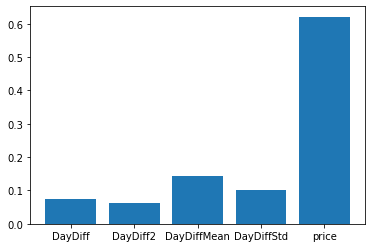

In [46]:
plt.bar([x for x in range(len(clf.feature_importances_))], clf.feature_importances_)
names = plt.xticks(np.arange(5), retained.columns[:-1])